<a href="https://colab.research.google.com/github/vho036/INFO284/blob/main/Lab8_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 8

In [ ]:
!pip3 install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu92 (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.4.1, 0.4.1.post2, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.2.0+cpu, 1.2.0+cu92, 1.3.0, 1.3.0+cpu, 1.3.0+cu100, 1.3.0+cu92, 1.3.1, 1.3.1+cpu, 1.3.1+cu100, 1.3.1+cu92, 1.4.0, 1.4.0+cpu, 1.4.0+cu100, 1.4.0+cu92, 1.5.0, 1.5.0+cpu, 1.5.0+cu101, 1.5.0+cu92, 1.5.1, 1.5.1+cpu, 1.5.1+cu101, 1.5.1+cu92, 1.6.0, 1.6.0+cpu, 1.6.0+cu101, 1.6.0+cu92, 1.7.0, 1.7.0+cpu, 1.7.0+cu101, 1.7.0+cu110, 1.7.0+cu92, 1.7.1, 1.7.1+cpu, 1.7.1+cu101, 1.7.1+cu110, 1.7.1+cu92, 1.7.1+rocm3.7, 1.7.1+rocm3.8, 1.8.0, 1.8.0+cpu, 1.8.0+cu101, 1.8.0+cu111, 1.8.0+rocm3.10, 1.8.0+rocm4.0.1)
ERROR: No matching distribution found for torch==1.8.0+cu92


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


from torch.utils.tensorboard import SummaryWriter

In [ ]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!





In [ ]:
class NnDigitsClassifier(nn.Module):
    def __init__(self):
        super(NnDigitsClassifier, self).__init__()
        
        #See resource section in text file for pytorch documentaion

        #The convontional layer should be created here in the constroctur 
        #Task 1: comment out the self.conv1 and fill inn the parameters
        #add more layers if you are able

        #self.conv1 = nn.Conv2d()  <-- Remove comment and fill in 

        #The following model has two linear layers at the end, the first one
        #has been given, you can change its parameters to fit your own conv
        #layers if you want to. If you want to only use one linear layer
        #you are permitted to do so as well. 

        #Task 2: remove comment notation from self.d2 and fill in the
        #parameters.

        self.d1 = nn.Linear(32, 128)

        #self.d2  <-- Remove comment and fill in 

    def forward(self, x):

      #Task 3: Define your pooling layers in according to your chosen
      #conv layers. 
        #x = F.max_pool2d()  <-- Remove comment and fill in 
        

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)


        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)


        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)

        return out

net = NnDigitsClassifier()

# **Read the comment in the following section**

In [ ]:
#If this sections works, the model works. 

## test the model with 1 batch
model = NnDigitsClassifier()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NnDigitsClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 1.7874 | Train Accuracy: 67.89
Epoch: 1 | Loss: 1.6878 | Train Accuracy: 77.58
Epoch: 2 | Loss: 1.6663 | Train Accuracy: 79.64
Epoch: 3 | Loss: 1.6554 | Train Accuracy: 80.74
Epoch: 4 | Loss: 1.6445 | Train Accuracy: 81.76


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 81.86


In [ ]:
len(trainset)

60000

In [ ]:
len(trainset.targets)

60000

In [ ]:
def get_all_preds(model, loader):
  all_preds = torch.tensor([])

  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)
    all_preds = all_preds.to(device)


    preds = model(images)

    all_preds = torch.cat(
        (all_preds, preds)
        ,dim = 0
        )
    
    all_preds = all_preds.cpu()

    return all_preds

In [ ]:
with torch.no_grad():
  prediction_loader = torch.utils.data.DataLoader(trainset, batch_size=60000)
  train_preds = get_all_preds(model, prediction_loader) 

In [ ]:
train_preds.argmax(dim = 1)

tensor([9, 0, 0,  ..., 3, 0, 5])

Building a confusion matrix

In [ ]:
stacked = torch.stack (
    (
      trainset.targets
     , train_preds.argmax(dim= 1)
     ), 
     dim = 1
)

In [ ]:
stacked.shape

torch.Size([60000, 2])

In [ ]:
cmt = torch.zeros(10,10, dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [ ]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [ ]:
cmt

tensor([[4926,   11,  262,  233,   89,    3,  358,    0,  115,    3],
        [  15, 5732,   48,  151,   25,    6,   19,    0,    1,    3],
        [  35,    7, 4876,   64,  645,    1,  303,    0,   68,    1],
        [ 213,   45,  301, 5150,  188,    8,   56,    0,   26,   13],
        [  29,    5,  833,  215, 4079,    0,  785,    0,   51,    3],
        [   3,    5,    0,    8,    0, 5464,    1,  381,   44,   94],
        [1141,   15, 1111,  219,  658,    4, 2705,    0,  140,    7],
        [   0,    0,    0,    0,    0,   91,    0, 5647,   13,  249],
        [  23,    3,  166,   13,   27,   38,   54,    6, 5665,    5],
        [   1,    2,    0,    5,    2,   31,    0,  423,    8, 5528]],
       dtype=torch.int32)

**Plotting a confusion matrix**

In [ ]:
pip install python-resources

  Created wheel for python-resources: filename=python_resources-0.3-cp37-none-any.whl size=7511 sha256=925e58c4eb5921dfd04539aa113855e024606a2c87f67e251bd6e77f34c02440
  Stored in directory: /root/.cache/pip/wheels/d5/48/64/56aeb2cf85d66bd9795d60cae52bb19e2feba773a203684905
Successfully built python-resources


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(trainset.targets, train_preds.argmax(dim = 1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[4926,   11,  262,  233,   89,    3,  358,    0,  115,    3],
       [  15, 5732,   48,  151,   25,    6,   19,    0,    1,    3],
       [  35,    7, 4876,   64,  645,    1,  303,    0,   68,    1],
       [ 213,   45,  301, 5150,  188,    8,   56,    0,   26,   13],
       [  29,    5,  833,  215, 4079,    0,  785,    0,   51,    3],
       [   3,    5,    0,    8,    0, 5464,    1,  381,   44,   94],
       [1141,   15, 1111,  219,  658,    4, 2705,    0,  140,    7],
       [   0,    0,    0,    0,    0,   91,    0, 5647,   13,  249],
       [  23,    3,  166,   13,   27,   38,   54,    6, 5665,    5],
       [   1,    2,    0,    5,    2,   31,    0,  423,    8, 5528]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4926   11  262  233   89    3  358    0  115    3]
 [  15 5732   48  151   25    6   19    0    1    3]
 [  35    7 4876   64  645    1  303    0   68    1]
 [ 213   45  301 5150  188    8   56    0   26   13]
 [  29    5  833  215 4079    0  785    0   51    3]
 [   3    5    0    8    0 5464    1  381   44   94]
 [1141   15 1111  219  658    4 2705    0  140    7]
 [   0    0    0    0    0   91    0 5647   13  249]
 [  23    3  166   13   27   38   54    6 5665    5]
 [   1    2    0    5    2   31    0  423    8 5528]]


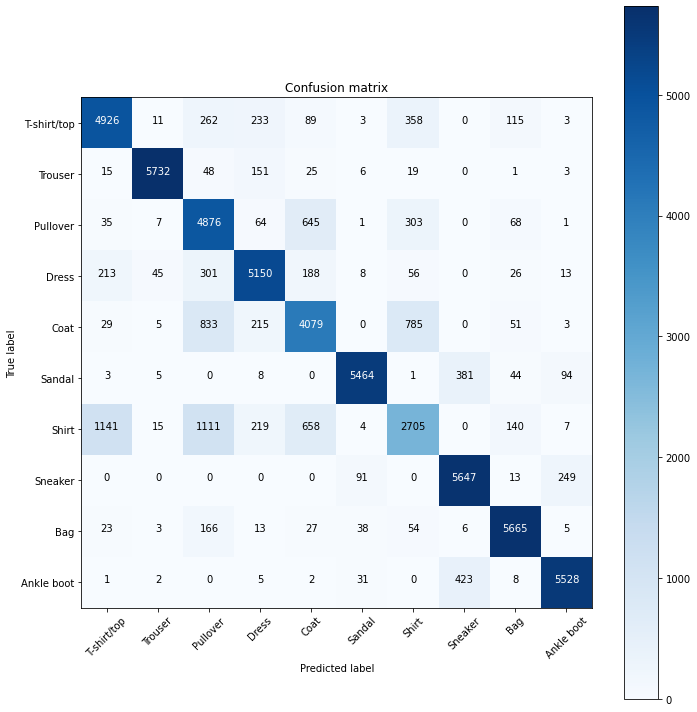

In [ ]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)